In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
data = pd.read_csv('data/model1_data_cleaned.csv', index_col=['user_id','book_id'])

In [5]:
data.head()

rating  user_avg_rating  \
user_id                          book_id                             
000192962b87d560f00b06fdcbd71681 30025791       5              5.0   
0005a08accd53b1e19c52109a1f478cb 59960          0              3.4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194       5              5.0   
0008931c0cde961e9c802c5a58196d23 500503         5              5.0   
                                 6081685        5              5.0   

                                           book_cluster  \
user_id                          book_id                  
000192962b87d560f00b06fdcbd71681 30025791             0   
0005a08accd53b1e19c52109a1f478cb 59960                4   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194             0   
0008931c0cde961e9c802c5a58196d23 500503               1   
                                 6081685              1   

                                           user_avg_rating_by_cluster  \
user_id                          book_id                                
000192962b87d560f00b06fdcbd71681 30025791                         5.0   
0005a08accd53b1e19c52109a1f478cb 59960                            0.0   
000700ecd5db3a9b0c4e392ed2e4f70b 11790194                         5.0   
0008931c0cde961e9c802c5a58196d23 500503                           5.0   
                                 6081685                          5.0   

                                           book_avg_rating  
user_id                          book_id                    
000192962b87d560f00b06fdcbd71681 30025791             4.19  
0005a08accd53b1e19c52109a1f478cb 59960                4.25  
000700ecd5db3a9b0c4e392ed2e4f70b 11790194             4.04  
0008931c0cde961e9c802c5a58196d23 500503               4.29  
                                 6081685              4.40

# Preprocessing & Modeling

I've got my data set up from the prior notebook. Ready for preprocessing and dividing into training sets.

In [8]:
from sklearn.preprocessing import StandardScaler

# Define X, y
X = data.drop('rating', axis=1)
y = data.rating

# Preprocessing
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [9]:
# Split into training/testing sets
from sklearn.model_selection import train_test_split

y = y.ravel()
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=2)

# Model 1: KNN

First I'm going to use a K-Nearest Neighbors model. This is a really simply model, but at least gives me a starting place.

In [10]:
# First will just run it "out of the box"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
knn = KNeighborsClassifier()
model_1 = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.52
Precision: 0.48
Recall: 0.45
F1 Score: 0.46


This first, basic model, has accuracy of 52% - not great, by this or other metrics. I'm going to use GridSearch to see if other k's give better performance metrics.

Then, I'll try a couple other algorithms on this base model to get an idea of if any is better than any other.

Then I'll move into stage 2 of my model which adds the sentiment analysis of the review text. That will be a new feature: whether the review was negative, positive or neutral.

In [12]:
# KNN with GridSearch to see if there's a better k to use
from sklearn.model_selection import GridSearchCV

grid_params = {
    'n_neighbors' : [5,7,9,11,13],
    'weights' : ['uniform', 'distance']
}

gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose=1, cv=3)

gs_results = gs.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.9min finished


In [14]:
print('Best Parameters: {}'.format(gs_results.best_params_))
print('Bset Score: {}'.format(gs_results.best_score_))

Best Parameters: {'n_neighbors': 13, 'weights': 'uniform'}
Bset Score: 0.5439038553267385


So, with KNN, bumping k up to 13 increased accuracy a few %. Not enough to make much of a difference. Let's look at a couple different algorithms and then see if adding some additional features helps much.

# Model 2: Decision Tree

Let's try using a decision tree model.

In [20]:
from sklearn.tree import DecisionTreeClassifier

model_2 = DecisionTreeClassifier(criterion='gini',max_depth=3)

model_2.fit(X_train, y_train)

y_pred = model_2.predict(X_test)

In [21]:
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
print('Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('F1 Score: {:.2f}'.format(f1_score(y_test, y_pred, average='macro')))

Accuracy: 0.53
Precision: 0.44
Recall: 0.38
F1 Score: 0.39


C:\Users\mdurr\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


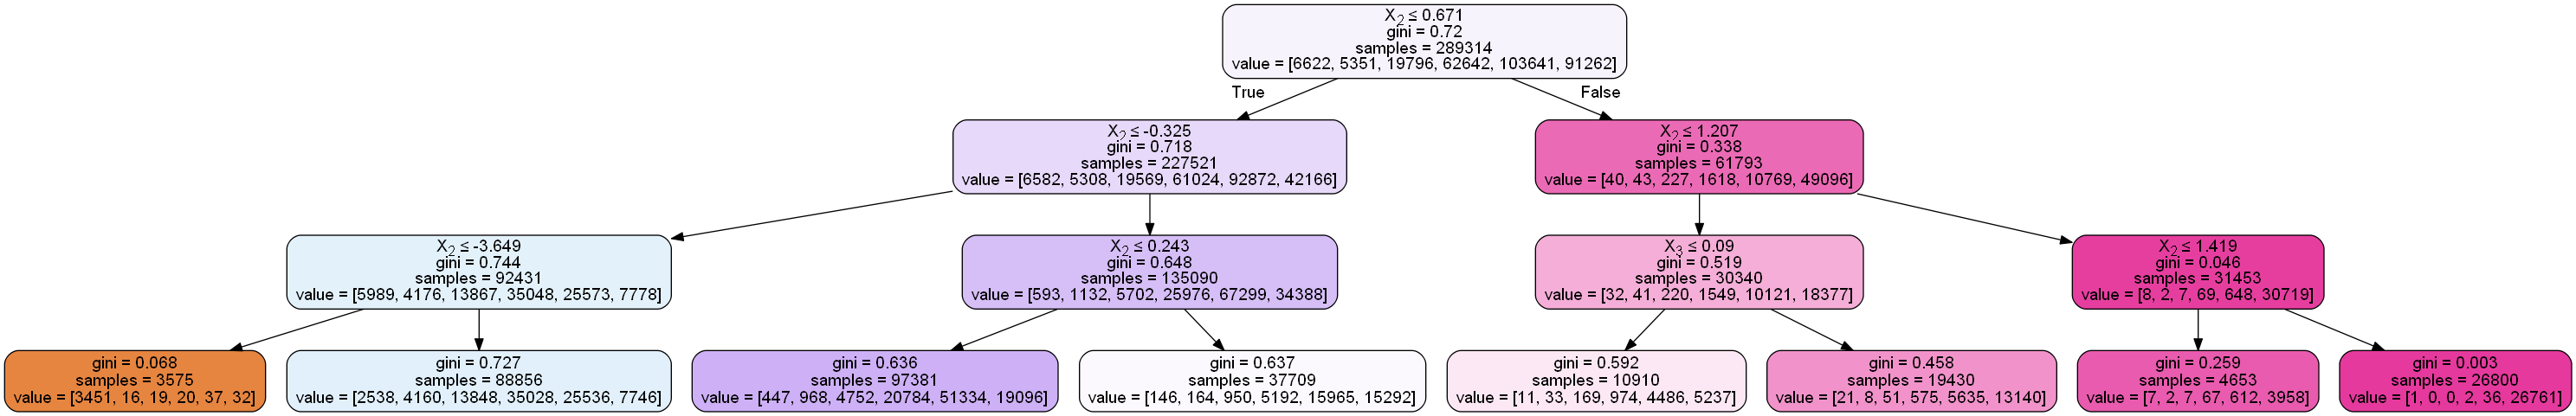

In [30]:
# Visualize the tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz

dot_data = StringIO()

# We can do so with export_graphviz
export_graphviz(model_2, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True,  
                    )

# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

So this basic decision tree is slightly more accurate, but more prone to false negatives/positives than the KNN model. Let's try a couple different tree depths and see if there's any improvement.

# Model 3: Random Forest